In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr

df = pd.read_csv("topic21_v40_train.csv")

new = df.dropna()
X = new.drop(columns="price")
y = new["price"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
X_train.info()
train_df = pd.concat([X_train,y_train],axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 3499 entries, 7756 to 1605
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   0                   3499 non-null   float64
 1   1                   3499 non-null   float64
 2   2                   3499 non-null   float64
 3   3                   3499 non-null   float64
 4   4                   3499 non-null   float64
 5   brand               3499 non-null   object 
 6   model               3499 non-null   object 
 7   trim                3499 non-null   object 
 8   body_type           3499 non-null   object 
 9   fuel_type           3499 non-null   object 
 10  transmission_type   3499 non-null   object 
 11  engine_capacity_cc  3499 non-null   object 
 12  horsepower          3499 non-null   object 
 13  exterior_color      3499 non-null   object 
 14  interior_color      3499 non-null   object 
 15  warranty            3499 non-null   object 
 16  city    

  feature        min        max
0       0 -19.739362  22.077654
1       1  -6.841693  -6.667216
2       2  -3.048133  15.843253
3       3   0.765860  41.943944
4       4   0.031420  16.027715


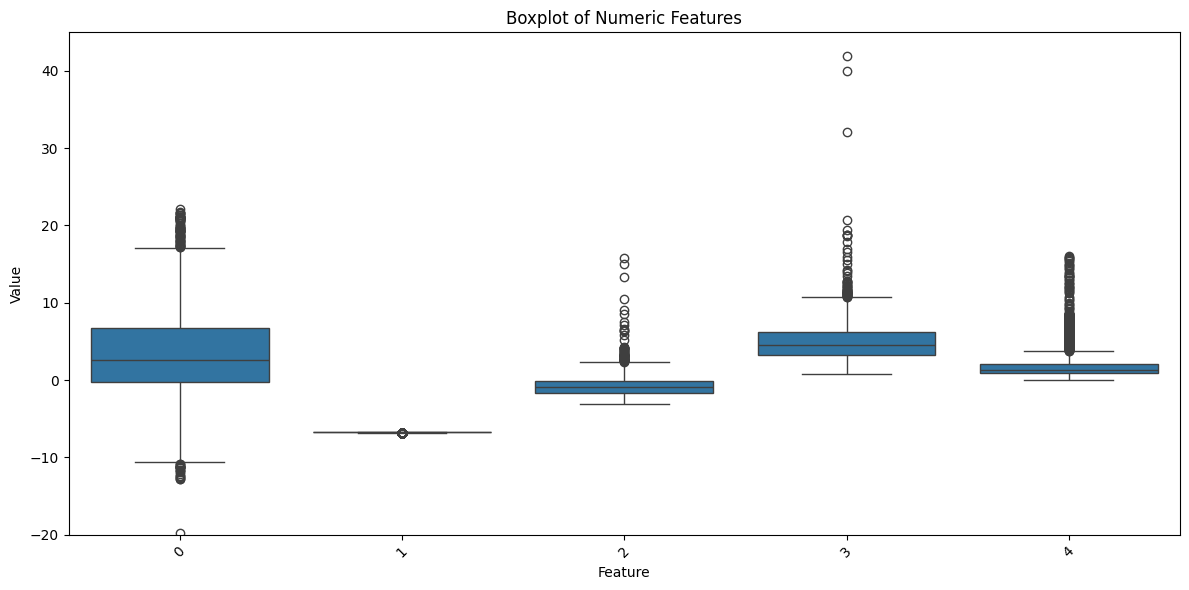

Outlier counts per feature:
0: 238
1: 735
2: 146
3: 113
4: 809


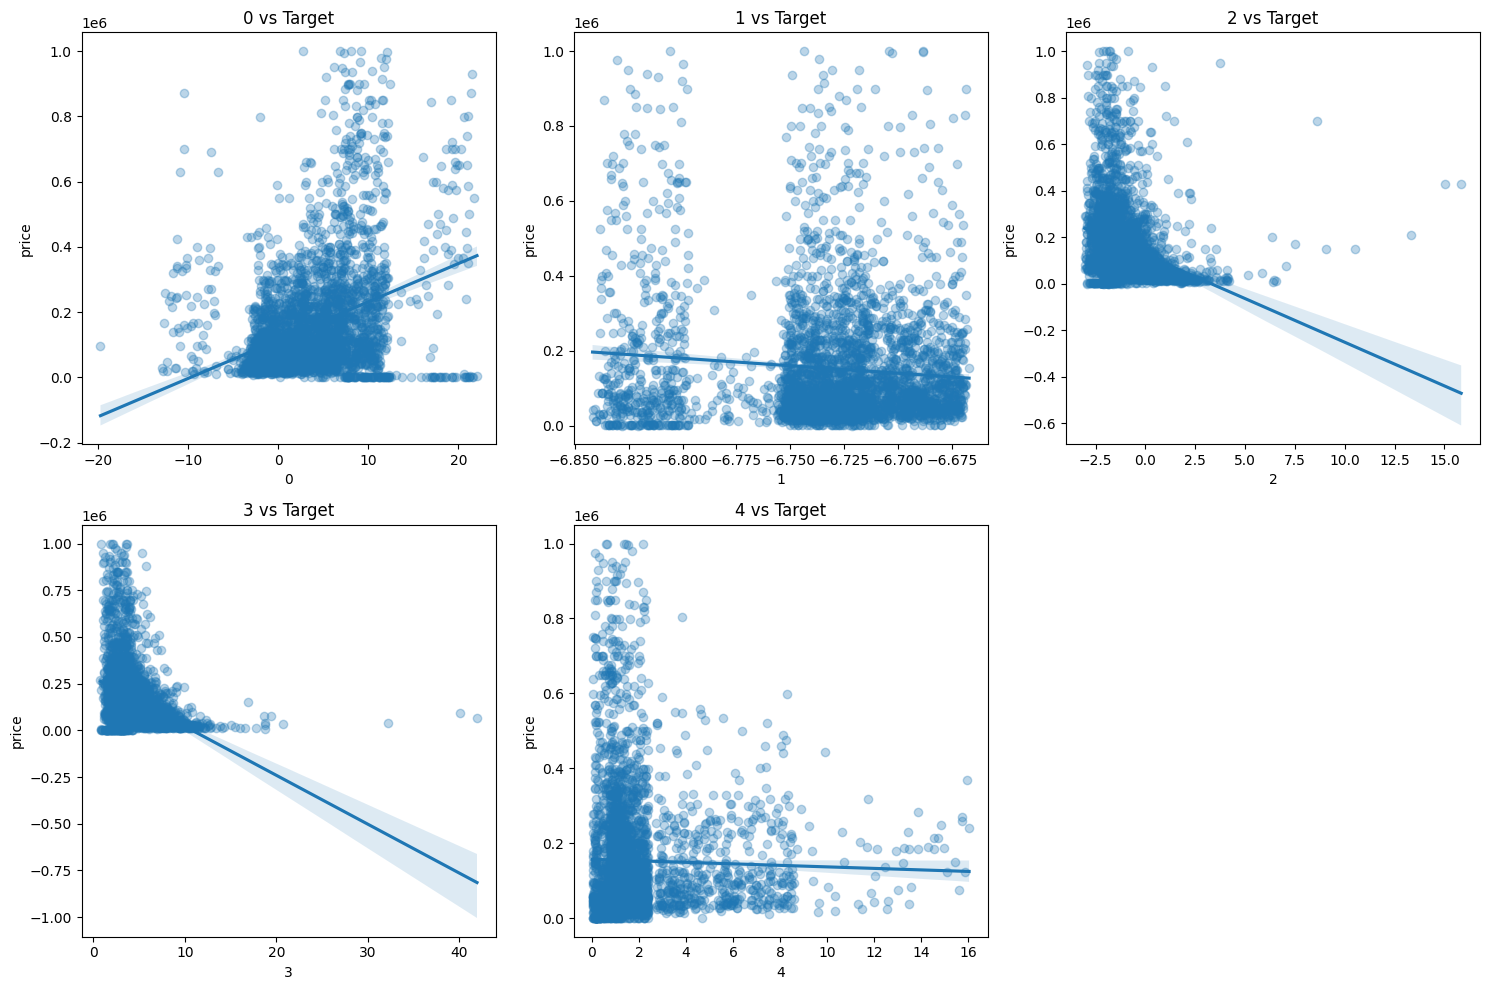

Verdict: notable linear relation with price for 0,2,4
 1,3 stay mostly constant --> deprioritize


In [3]:
numeric = X_train.select_dtypes(include=["int64", "float64"]).columns

min_max = pd.DataFrame({
    "feature": numeric,
    "min": X_train[numeric].min().values,
    "max": X_train[numeric].max().values
})
print(min_max)
df_long = X_train[min_max['feature']].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', data=df_long)
plt.xticks(rotation=45)
plt.title('Boxplot of Numeric Features')
plt.ylim(-20,45)
plt.tight_layout()
plt.show()
features = min_max['feature']

outlier_counts = {}
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)][feature]
    outlier_counts[feature] = outliers.count()

print("Outlier counts per feature:")
for feature, count in outlier_counts.items():
    print(f"{feature}: {count}")
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric, 1):
    plt.subplot(2, 3, i)
    sns.regplot(x=X_train[col], y=y_train, scatter_kws={'alpha':0.3})
    plt.title(f'{col} vs Target')
plt.tight_layout()
plt.show()
print("Verdict: notable linear relation with price for 0,2,4\n 1,3 stay mostly constant --> deprioritize")


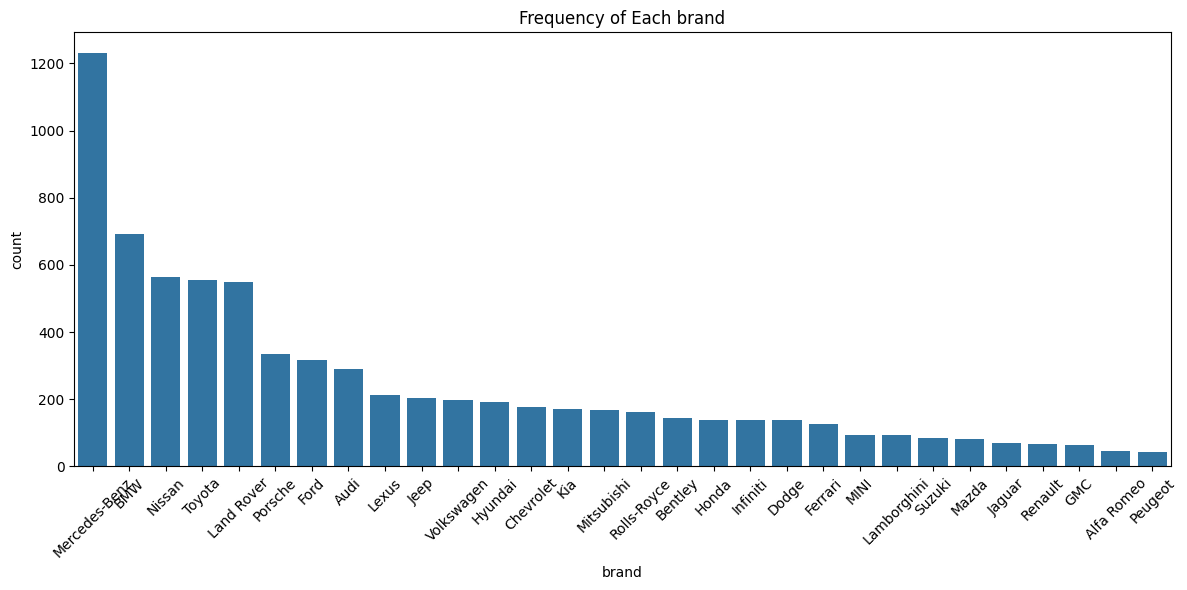

Total amount of brands: 75
Amount of cars belonging to most common brand: 535 ( Mercedes-Benz )
Amount of cars belonging to 30th most common brand: 22 ( Peugeot )
Top 30 brands make up 93.08% of all cars.


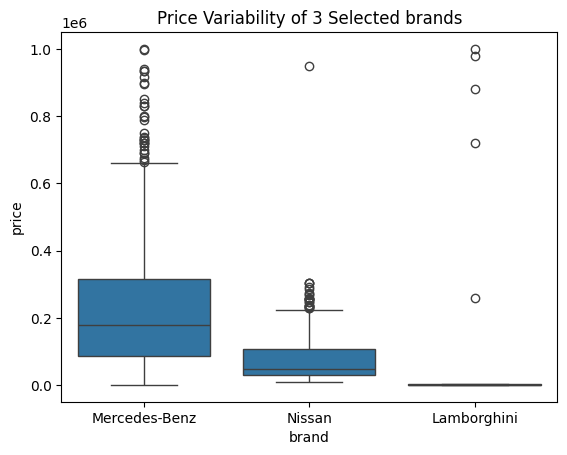

        brand  Total Count  Outlier Count  % Outliers
Mercedes-Benz          535             31        5.79
       Nissan          286             24        8.39
  Lamborghini           27              5       18.52

Verdict: some accurate predictors, but overall noisy dataset
 --> not a strong predictor of price by itself


In [3]:

brand_totals = X_train["brand"].value_counts().reindex()
brand_totals.columns = ["Brand","Count"]
brand_counts = X_train["brand"].value_counts().head(30)
brand_df = brand_counts.reindex()
brand_df.columns = ['Brand', 'Count']
top_30_brands = train_df['brand'].value_counts().nlargest(30).index.to_list()


brands_top30 = df[df['brand'].isin(top_30_brands)]
plt.figure(figsize=(12, 6))
sns.countplot(x='brand', data=brands_top30, order=brands_top30['brand'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequency of Each brand')
plt.tight_layout()
plt.show()

first = train_df["brand"].value_counts().iloc[0]
thirty = train_df["brand"].value_counts().iloc[29] 
total = train_df["brand"].nunique()
print("Total amount of brands:", total)
print("Amount of cars belonging to most common brand:", first,"(",brand_counts.index[0],")")
print("Amount of cars belonging to 30th most common brand:", thirty,"(",brand_counts.index[29],")")

top30sum = train_df[train_df["brand"].isin(top_30_brands)].shape[0]
totalsum = train_df["brand"].count()
percentage = top30sum / totalsum * 100
print(f"Top 30 brands make up {percentage:.2f}% of all cars.")

selection = ["Mercedes-Benz","Nissan","Lamborghini"]
subset = train_df[train_df['brand'].isin(selection)].copy()
subset = subset[subset["price"].notna()]
sns.boxplot(data=subset, x='brand', y='price',order = selection)
plt.title("Price Variability of 3 Selected brands")
plt.show()
feature_col = 'brand'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: some accurate predictors, but overall noisy dataset\n --> not a strong predictor of price by itself")


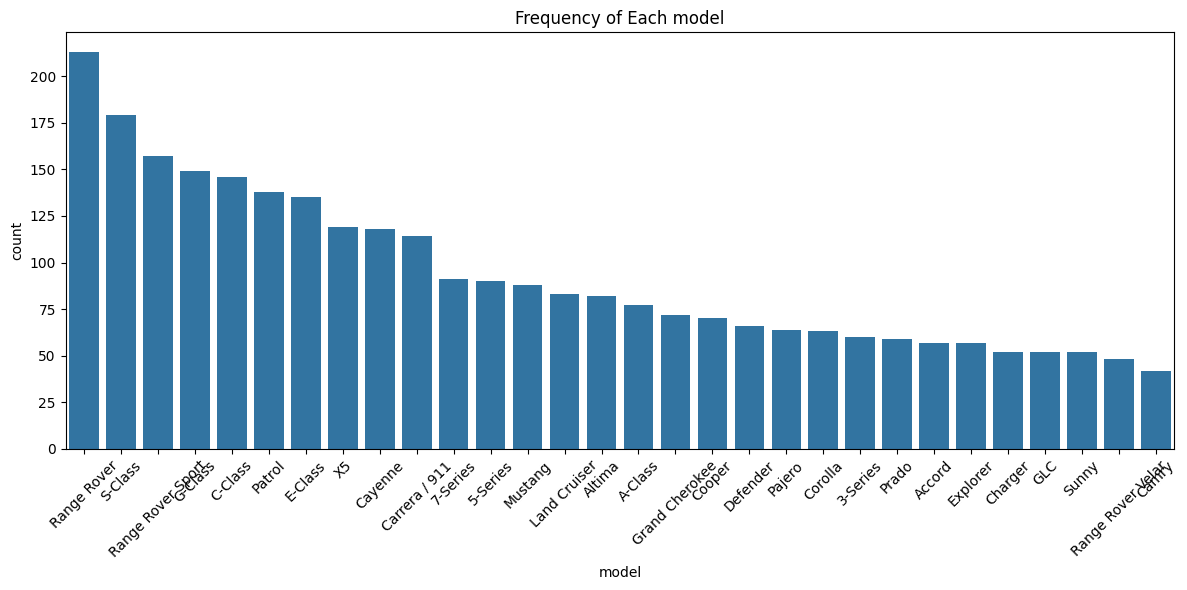

Total amount of models: 496
Amount of cars belonging to most common model: 85 ( Range Rover )
Amount of cars belonging to 30th most common model: 26 ( Land Cruiser )
Top 30 models make up 35.98% of all cars.


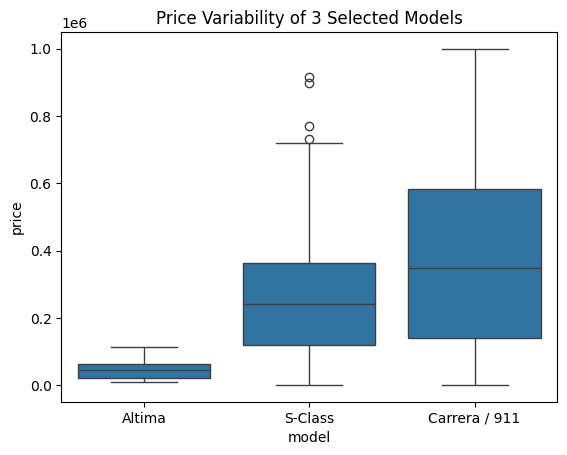

        model  Total Count  Outlier Count  % Outliers
       Altima           51              0        0.00
      S-Class           68              4        5.88
Carrera / 911           43              0        0.00

Verdict: Inconsistent price ranges per model
 --> not a strong predictor of price by itself


In [ ]:

model_totals = X_train["model"].value_counts().reset_index()
model_totals.columns = ["model","Count"]
model_counts = X_train["model"].value_counts().head(30)
model_df = model_counts.reset_index()
model_df.columns = ['model', 'Count']
top_30_models = train_df['model'].value_counts().nlargest(30).index


models_top30 = df[df['model'].isin(top_30_models)]
plt.figure(figsize=(12, 6))
sns.countplot(x='model', data=models_top30, order=models_top30['model'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequency of Top 30 models')
plt.tight_layout()
plt.show()

first = train_df["model"].value_counts().iloc[0]
thirty = train_df["model"].value_counts().iloc[29] 
total = train_df["model"].nunique()
print("Total amount of models:", total)
print("Amount of cars belonging to most common model:", first,"(",model_counts.index[0],")")
print("Amount of cars belonging to 30th most common model:", thirty,"(",model_counts.index[29],")")

top30sum = train_df[train_df["model"].isin(top_30_models)].shape[0]
totalsum = train_df["model"].count()
percentage = top30sum / totalsum * 100
print(f"Top 30 models make up {percentage:.2f}% of all cars.")

selection = ["Altima","S-Class",'Carrera / 911']
subset = train_df[train_df['model'].isin(selection)].copy()
subset = subset[subset["price"].notna()]
sns.boxplot(data=subset, x='model', y='price',order = selection)
plt.title("Price Variability of 3 Selected Models")
plt.show()
feature_col = 'model'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: Inconsistent price ranges per model\n --> not a strong predictor of price by itself")

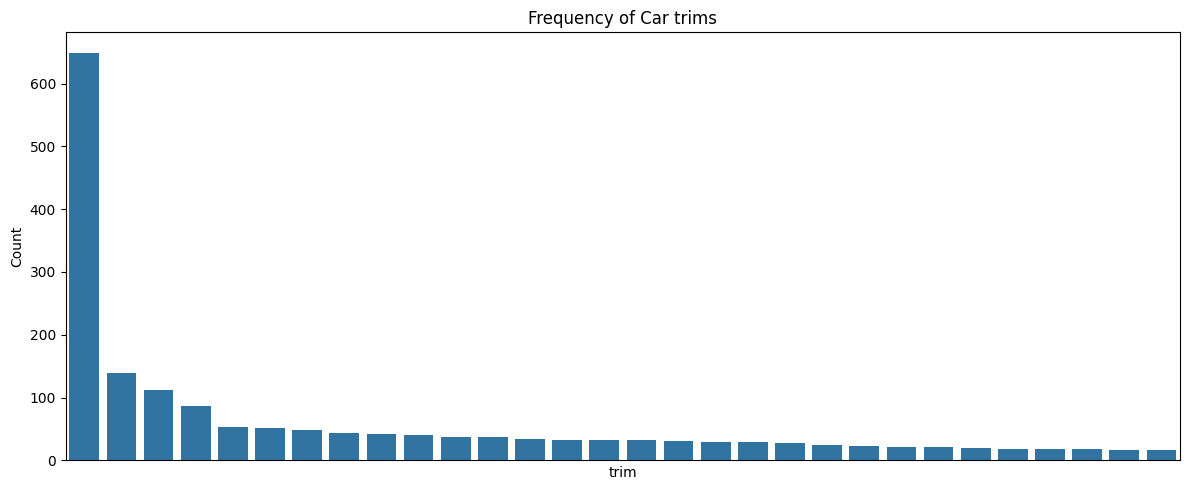

Total amount of trims: 578
Amount of cars belonging to most common trim: 649 ( Other )
Amount of cars belonging to 4th most common trim: 51 ( G 63 AMG )


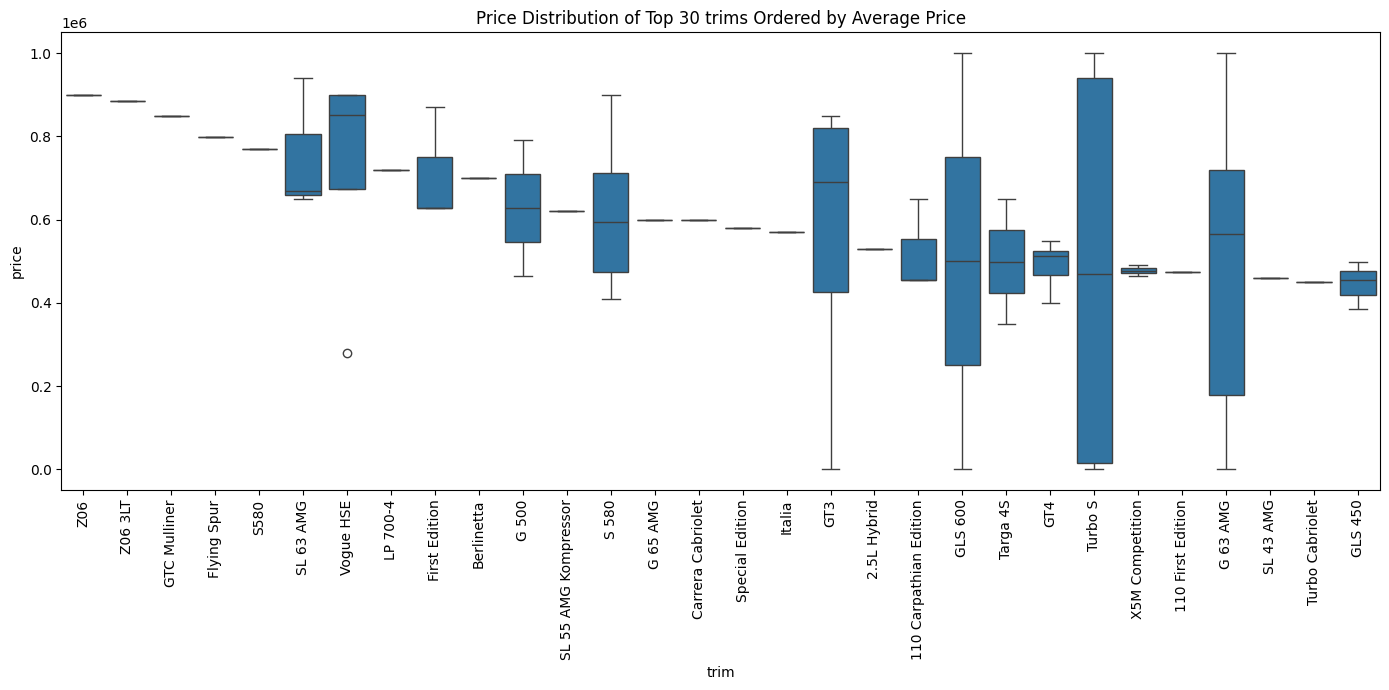

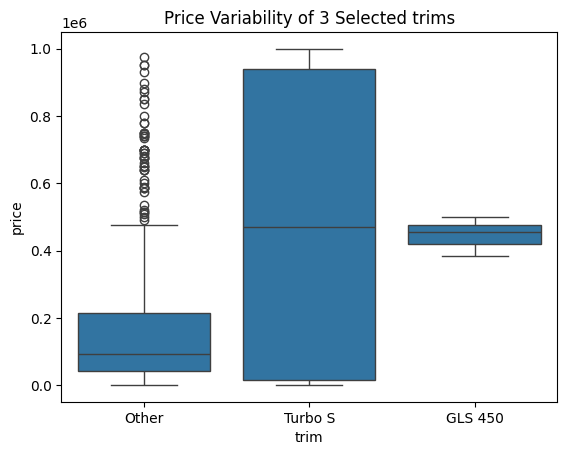

   trim  Total Count  Outlier Count  % Outliers
  Other          649             54        8.32
Turbo S            4              0        0.00
GLS 450            3              0        0.00

Verdict: mix of accurate predictors and inconsistent price ranges
 --> not a strong predictor by itself


In [4]:

trim_totals = X_train["trim"].value_counts().reset_index()
trim_totals.columns = ["trim","Count"]
trim_totals.to_csv("trim_totals.csv", index=False)
trim_counts = X_train["trim"].value_counts().head(30)
trim_df = trim_counts.reset_index()
trim_df.columns = ['trim', 'Count']

plt.figure(figsize=(12, 5))
sns.barplot(x="trim", y='Count', data=trim_df)
plt.title('Frequency of Car trims')
plt.xticks([],rotation=45)
plt.tight_layout()
plt.savefig("trim_plot.pdf")
plt.show()
first = train_df["trim"].value_counts().iloc[0]
thirty = train_df["trim"].value_counts().iloc[5] 
total = train_df["trim"].nunique()
print("Total amount of trims:", total)
print("Amount of cars belonging to most common trim:", first,"(",trim_counts.index[0],")")
print("Amount of cars belonging to 4th most common trim:", thirty,"(",trim_counts.index[5],")")
order = train_df.groupby('trim')['price'].mean().sort_values(ascending=False).index
top_30_trims = order[:30]  
subset = train_df[train_df['trim'].isin(top_30_trims)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='trim', y='price', order=top_30_trims)
plt.xticks(rotation=90)
plt.title('Price Distribution of Top 30 trims Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["Other","Turbo S",'GLS 450']
subset = train_df[train_df['trim'].isin(selection)].copy()
sns.boxplot(data=subset, x='trim', y='price',order = selection)
plt.title("Price Variability of 3 Selected trims")
plt.show()
feature_col = 'trim'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: mix of accurate predictors and inconsistent price ranges\n --> not a strong predictor by itself")

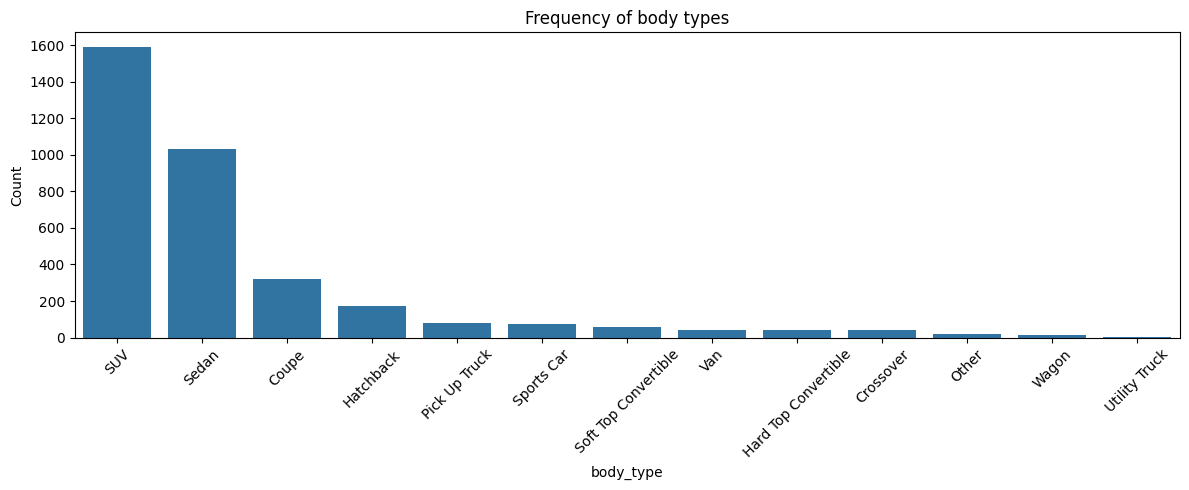

Total amount of body types: 13
Amount of cars belonging to most common body_type: 1590 ( SUV )
Amount of cars belonging to 4th most common body_type: 172 ( Hatchback )


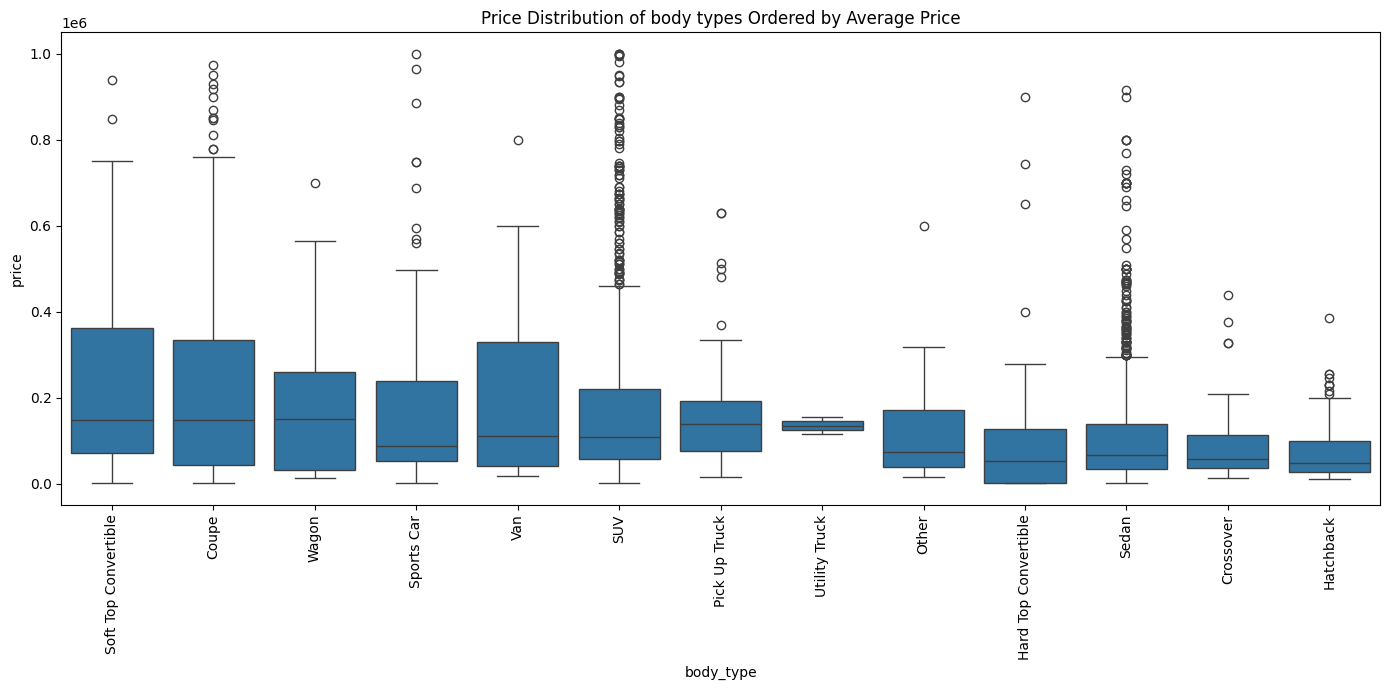

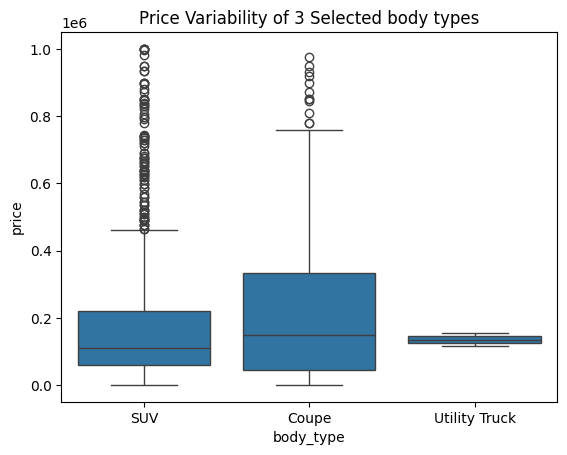

    body_type  Total Count  Outlier Count  % Outliers
          SUV         1590             94        5.91
        Coupe          323             12        3.72
Utility Truck            2              0        0.00

Verdict: Large overlap between price ranges of different types, inconistent price ranges
 --> likely not a strong predictor at all


In [7]:

body_type_totals = X_train["body_type"].value_counts().reset_index()
body_type_totals.columns = ["body_type","Count"]
body_type_totals.to_csv("body_type_totals.csv", index=False)
body_type_counts = X_train["body_type"].value_counts()
body_type_df = body_type_counts.reset_index()
body_type_df.columns = ['body_type', 'Count']

plt.figure(figsize=(12, 5))
sns.barplot(x="body_type", y='Count', data=body_type_df)
plt.title('Frequency of body types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("body_type_plot.pdf")
plt.show()
first = train_df["body_type"].value_counts().iloc[0]
thirty = train_df["body_type"].value_counts().iloc[3] 
total = train_df["body_type"].nunique()
print("Total amount of body types:", total)
print("Amount of cars belonging to most common body_type:", first,"(",body_type_counts.index[0],")")
print("Amount of cars belonging to 4th most common body_type:", thirty,"(",body_type_counts.index[3],")")
order = train_df.groupby('body_type')['price'].mean().sort_values(ascending=False).index
top_30_body_types = order[:30]  
subset = train_df[train_df['body_type'].isin(top_30_body_types)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='body_type', y='price', order=top_30_body_types)
plt.xticks(rotation=90)
plt.title('Price Distribution of body types Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["SUV","Coupe",'Utility Truck']
subset = train_df[train_df['body_type'].isin(selection)].copy()
sns.boxplot(data=subset, x='body_type', y='price',order = selection)
plt.title("Price Variability of 3 Selected body types")
plt.show()
feature_col = 'body_type'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: Large overlap between price ranges of different types, inconistent price ranges\n --> likely not a strong predictor at all")

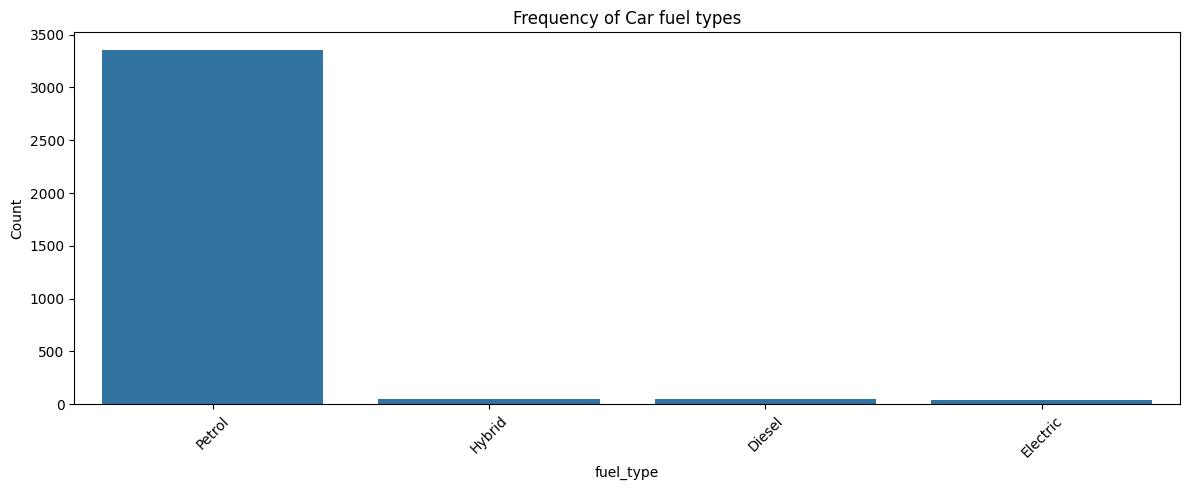

Total amount of fuel types: 4
Amount of cars belonging to most common fuel type: 3354 ( Petrol )
Amount of cars belonging to 2nd most common fuel type: 53 ( Hybrid )


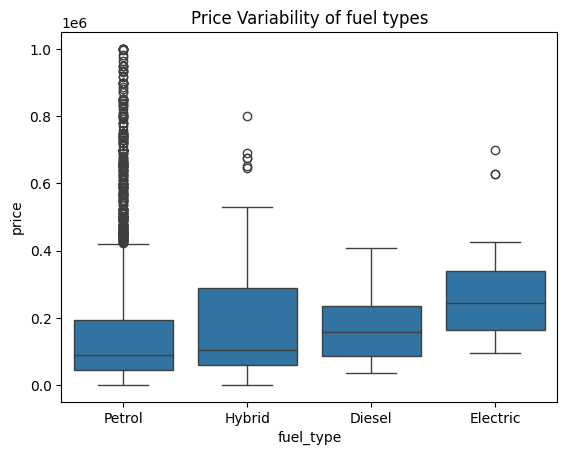

fuel_type  Total Count  Outlier Count  % Outliers
   Petrol         3354            244        7.27
   Hybrid           53              6       11.32
   Diesel           51              0        0.00
 Electric           41              3        7.32

Verdict: Very imbalanced categories, relatively frequent outlieres, large overlap between price ranges
 --> not a strong predictor by itself


In [10]:

fuel_type_totals = X_train["fuel_type"].value_counts().reset_index()
fuel_type_totals.columns = ["fuel_type","Count"]
fuel_type_totals.to_csv("fuel_type_totals.csv", index=False)
fuel_type_counts = X_train["fuel_type"].value_counts()
fuel_type_df = fuel_type_counts.reset_index()
fuel_type_df.columns = ['fuel_type', 'Count']
plt.figure(figsize=(12, 5))
sns.barplot(x="fuel_type", y='Count', data=fuel_type_df)
plt.title('Frequency of Car fuel types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("fuel_type_plot.pdf")
plt.show()
first = train_df["fuel_type"].value_counts().iloc[0]
thirty = train_df["fuel_type"].value_counts().iloc[1] 
total = train_df["fuel_type"].nunique()
print("Total amount of fuel types:", total)
print("Amount of cars belonging to most common fuel type:", first,"(",fuel_type_counts.index[0],")")
print("Amount of cars belonging to 2nd most common fuel type:", thirty,"(",fuel_type_counts.index[1],")")
order = train_df.groupby('fuel_type')['price'].mean().sort_values(ascending=False).index
top_30_fuel_types = order[:30]  
subset = train_df[train_df['fuel_type'].isin(top_30_fuel_types)]
selection = ["Petrol","Hybrid","Diesel","Electric"]
subset = train_df[train_df['fuel_type'].isin(selection)].copy()
sns.boxplot(data=subset, x='fuel_type', y='price',order = selection)
plt.title("Price Variability of fuel types")
plt.show()
feature_col = 'fuel_type'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: Very imbalanced categories, relatively frequent outlieres, large overlap between price ranges\n --> not a strong predictor by itself")

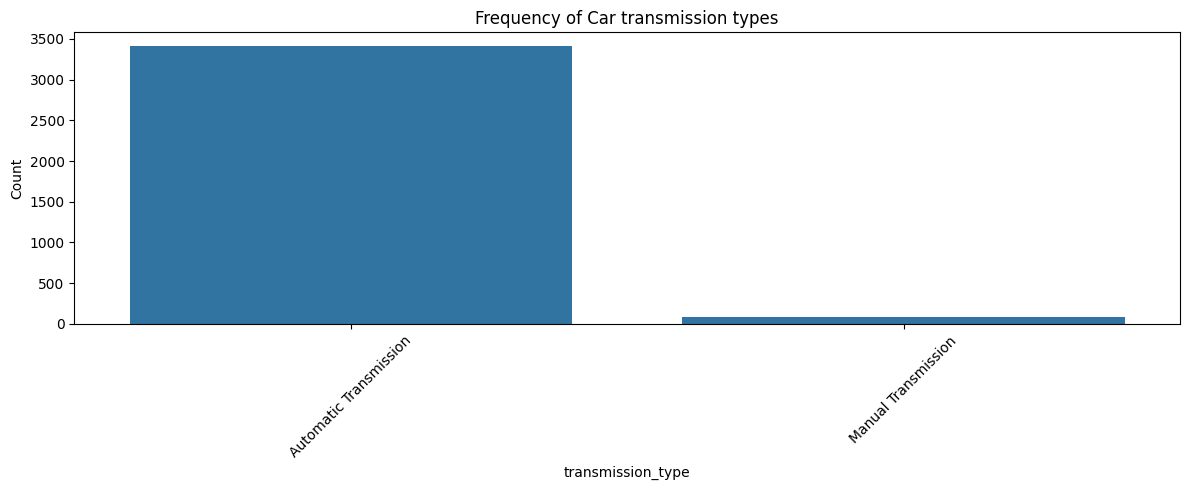

Total amount of transmission types: 2
Amount of cars belonging to most common transmission type: 3411 ( Automatic Transmission )
Amount of cars belonging to 2nd most common transmission type: 88 ( Manual Transmission )


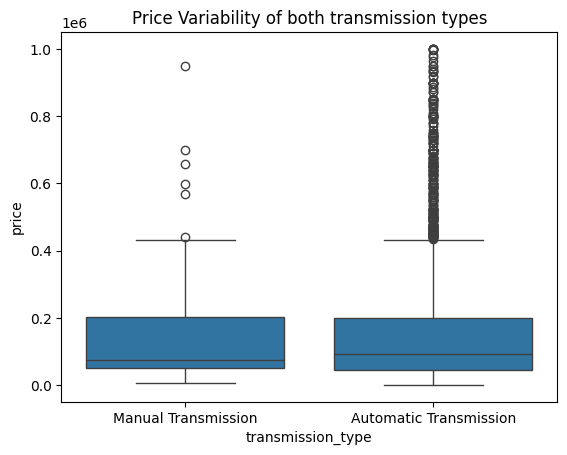

     transmission_type  Total Count  Outlier Count  % Outliers
   Manual Transmission           88              6        6.82
Automatic Transmission         3411            241        7.07

Verdict: nearly identical IQRs, similar relative amount of outliers
 --> likely not a strong predictor 


In [12]:

transmission_type_totals = X_train["transmission_type"].value_counts().reset_index()
transmission_type_totals.columns = ["transmission_type","Count"]
transmission_type_totals.to_csv("transmission_type_totals.csv", index=False)
transmission_type_counts = X_train["transmission_type"].value_counts()
transmission_type_df = transmission_type_counts.reset_index()
transmission_type_df.columns = ['transmission_type', 'Count']
transmission_type_df.columns = ['transmission_type', 'Count']
plt.figure(figsize=(12, 5))
sns.barplot(x="transmission_type", y='Count', data=transmission_type_df)
plt.title('Frequency of Car transmission types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("transmission_type_plot.pdf")
plt.show()
first = train_df["transmission_type"].value_counts().iloc[0]
thirty = train_df["transmission_type"].value_counts().iloc[1] 
total = train_df["transmission_type"].nunique()
print("Total amount of transmission types:", total)
print("Amount of cars belonging to most common transmission type:", first,"(",transmission_type_counts.index[0],")")
print("Amount of cars belonging to 2nd most common transmission type:", thirty,"(",transmission_type_counts.index[1],")")
order = train_df.groupby('transmission_type')['price'].mean().sort_values(ascending=False).index
top_30_transmission_types = order[:30]  
subset = train_df[train_df['transmission_type'].isin(top_30_transmission_types)]
selection = ["Manual Transmission","Automatic Transmission"]
subset = train_df[train_df['transmission_type'].isin(selection)].copy()
sns.boxplot(data=subset, x='transmission_type', y='price',order = selection)
plt.title("Price Variability of both transmission types")
plt.show()
feature_col = 'transmission_type'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: nearly identical IQRs, similar relative amount of outliers\n --> likely not a strong predictor ")

count               3499
unique                10
top       2000 - 2499 cc
freq                 716
Name: engine_capacity_cc, dtype: object


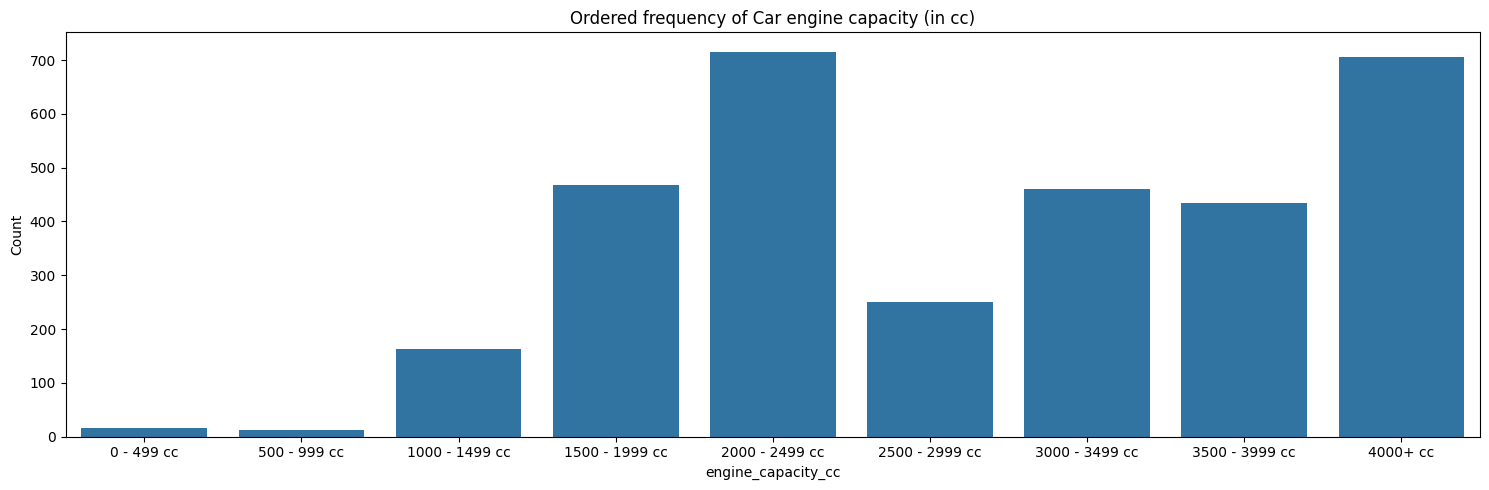

<Figure size 1000x500 with 0 Axes>

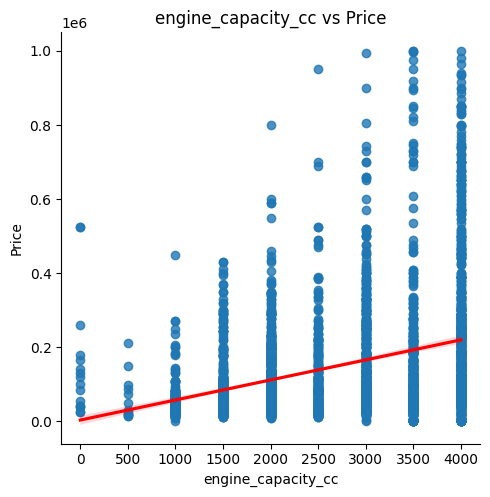

Correlation coefficient (r): 0.33
Verdict: weak positive linear relation between engine capacity and price
 --> potentially useful predictor


In [13]:
print(X_train["engine_capacity_cc"].describe())
engine_capacity_cc_totals = X_train["engine_capacity_cc"].value_counts().reset_index()
engine_capacity_cc_totals.columns = ["engine_capacity_cc","Count"]
engine_capacity_cc_totals.to_csv("engine_capacity_cc_totals.csv", index=False)
engine_capacity_cc_counts = X_train["engine_capacity_cc"].value_counts().head(300)
engine_capacity_cc_df = engine_capacity_cc_counts.reset_index()
engine_capacity_cc_df.columns = ['engine_capacity_cc', 'Count']
order =["0 - 499 cc","500 - 999 cc","1000 - 1499 cc","1500 - 1999 cc","2000 - 2499 cc","2500 - 2999 cc","3000 - 3499 cc","3500 - 3999 cc","4000+ cc"]

plt.figure(figsize=(15, 5))
sns.barplot(x="engine_capacity_cc", y='Count', data=engine_capacity_cc_df, order= order)
plt.title('Ordered frequency of Car engine capacity (in cc)')
plt.tight_layout()
plt.savefig("engine_capacity_cc_plot.pdf")

train_df['engine_capacity_cc'] = train_df['engine_capacity_cc'].replace(['Unknown'], np.nan)
train_df['engine_capacity_cc_numeric'] = (train_df['engine_capacity_cc'].astype(str).str.extract(r'(\d+)', expand=False).astype(float))

plt.figure(figsize=(10, 5))
sns.lmplot(data=train_df, x='engine_capacity_cc_numeric', y='price', line_kws={"color": "red"})
plt.title('engine_capacity_cc vs Price')
plt.xlabel('engine_capacity_cc')
plt.ylabel('Price')
plt.show()

valid = train_df[['price', 'engine_capacity_cc_numeric']].dropna()
r, p = pearsonr(valid['engine_capacity_cc_numeric'], valid['price'])

print(f"Correlation coefficient (r): {r:.2f}")
print("Verdict: weak positive linear relation between engine capacity and price\n --> potentially useful predictor")

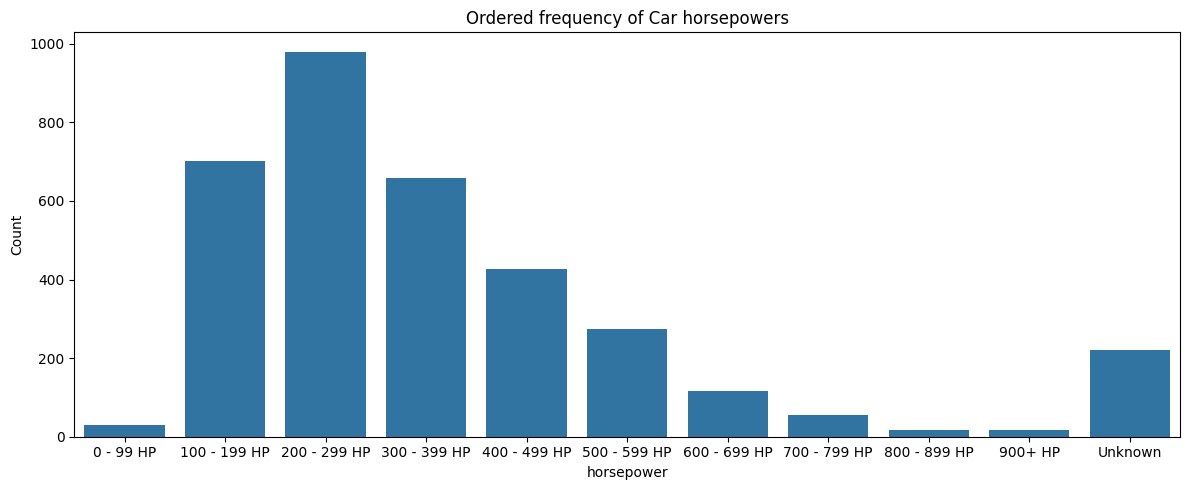

<Figure size 1000x500 with 0 Axes>

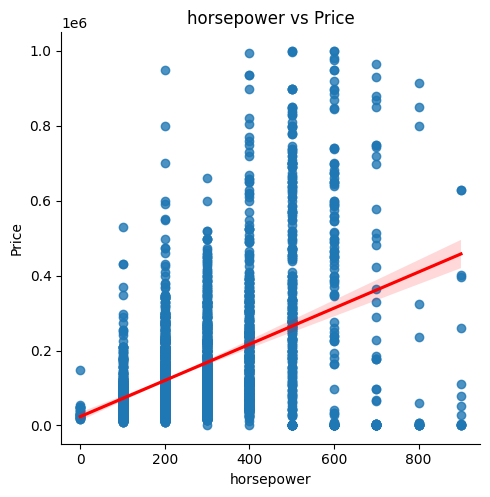

Correlation coefficient (r): 0.45
Verdict: moderate positive correlation with price
 --> potentially strong predictor 


In [14]:

horsepower_totals = X_train["horsepower"].value_counts().reset_index()
horsepower_totals.columns = ["horsepower","Count"]
horsepower_totals.to_csv("horsepower_totals.csv", index=False)
horsepower_counts = X_train["horsepower"].value_counts().head(300)
horsepower_df = horsepower_counts.reset_index()
horsepower_df.columns = ['horsepower', 'Count']
horses =["0 - 99 HP","100 - 199 HP","200 - 299 HP","300 - 399 HP","400 - 499 HP","500 - 599 HP","600 - 699 HP","700 - 799 HP","800 - 899 HP","900+ HP","Unknown"]

plt.figure(figsize=(12, 5))
sns.barplot(x="horsepower", y='Count', data=horsepower_df, order = horses)
plt.title('Ordered frequency of Car horsepowers')
plt.tight_layout()
plt.savefig("horsepower_plot.pdf")

train_df['horsepower'] = train_df['horsepower'].replace(['Unknown'], np.nan)
train_df['horsepower_numeric'] = (train_df['horsepower'].astype(str).str.extract(r'(\d+)', expand=False).astype(float))

plt.figure(figsize=(10, 5))
sns.lmplot(data=train_df, x='horsepower_numeric', y='price', line_kws={"color": "red"})
plt.title('horsepower vs Price')
plt.xlabel('horsepower')
plt.ylabel('Price')
plt.show()

valid = train_df[['price', 'horsepower_numeric']].dropna()
r, p = pearsonr(valid['horsepower_numeric'], valid['price'])

print(f"Correlation coefficient (r): {r:.2f}")
print("Verdict: moderate positive correlation with price\n --> potentially strong predictor ")





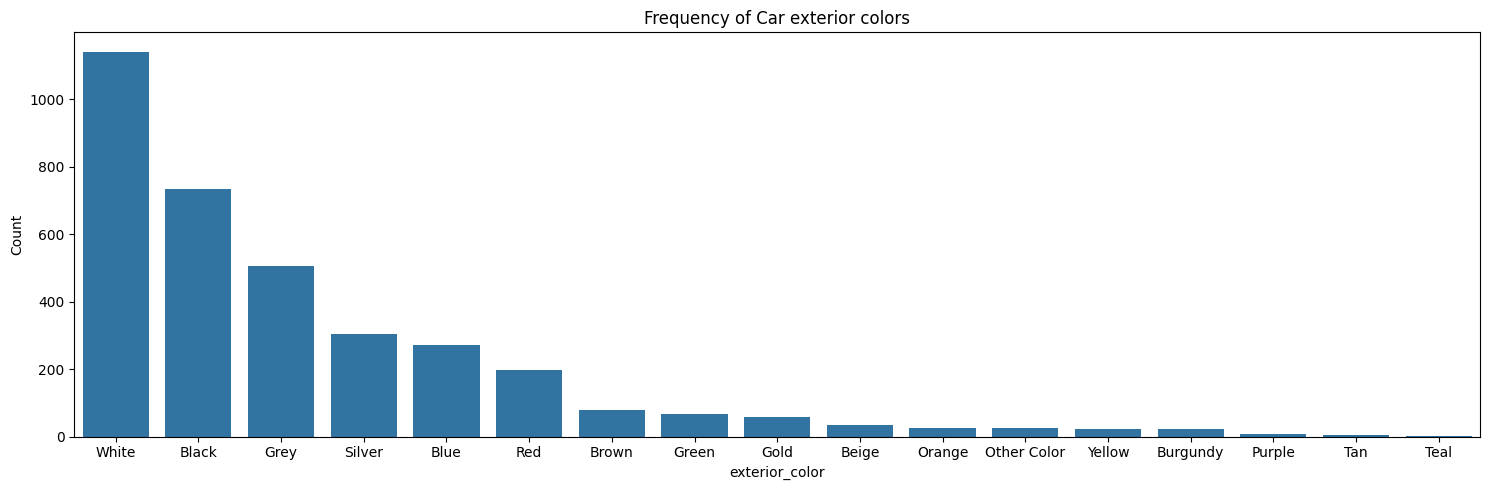

Total amount of exterior colors: 17
Amount of cars belonging to most common exterior color: 1141 ( White )
Amount of cars belonging to 4th most common exterior color: 304 ( Silver )


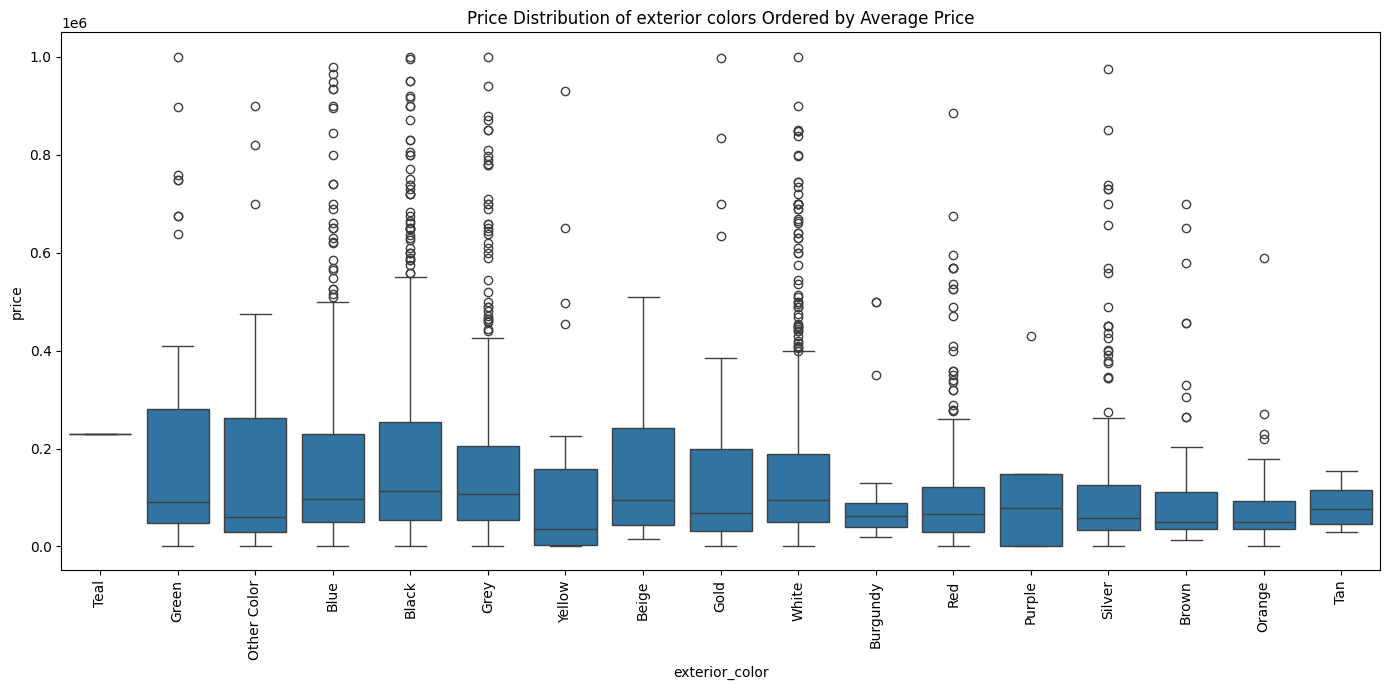

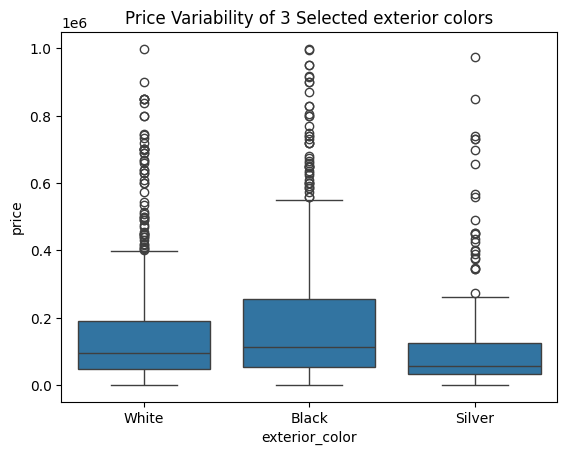

exterior_color  Total Count  Outlier Count  % Outliers
         White         1141             56        4.91
         Black          735             43        5.85
        Silver          304             24        7.89

Verdict: large IQRs for most colors, mosty similar medians
 --> probably not a strong predictor


In [20]:

exterior_color_totals = X_train["exterior_color"].value_counts().reset_index()
exterior_color_totals.columns = ["exterior_color","Count"]
exterior_color_totals.to_csv("exterior_color_totals.csv", index=False)
exterior_color_counts = X_train["exterior_color"].value_counts().head(300)
exterior_color_df = exterior_color_counts.reset_index()
exterior_color_df.columns = ['exterior_color', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x="exterior_color", y='Count', data=exterior_color_df)
plt.title('Frequency of Car exterior colors')
plt.tight_layout()
plt.savefig("exterior_color_plot.pdf")
plt.show()
first = train_df["exterior_color"].value_counts().iloc[0]
thirty = train_df["exterior_color"].value_counts().iloc[3] 
total = train_df["exterior_color"].nunique()
print("Total amount of exterior colors:", total)
print("Amount of cars belonging to most common exterior color:", first,"(",exterior_color_counts.index[0],")")
print("Amount of cars belonging to 4th most common exterior color:", thirty,"(",exterior_color_counts.index[3],")")
order = train_df.groupby('exterior_color')['price'].mean().sort_values(ascending=False).index
top_30_exterior_colors = order[:30]  
subset = train_df[train_df['exterior_color'].isin(top_30_exterior_colors)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='exterior_color', y='price', order=top_30_exterior_colors)
plt.xticks(rotation=90)
plt.title('Price Distribution of exterior colors Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["White","Black",'Silver']
subset = train_df[train_df['exterior_color'].isin(selection)].copy()
sns.boxplot(data=subset, x='exterior_color', y='price',order = selection)
plt.title("Price Variability of 3 Selected exterior colors")
plt.show()
feature_col = 'exterior_color'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: large IQRs for most colors, mosty similar medians\n --> probably not a strong predictor")

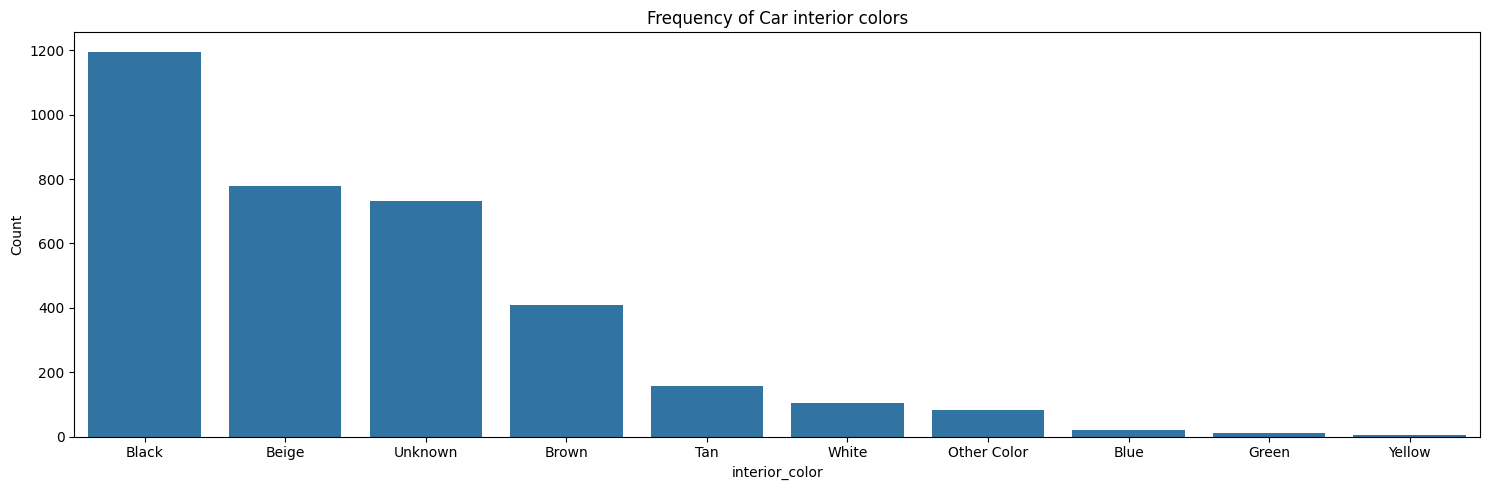

Total amount of interior colors: 10
Amount of cars belonging to most common interior color: 1196 ( Black )
Amount of cars belonging to 4th most common interior color: 408 ( Brown )


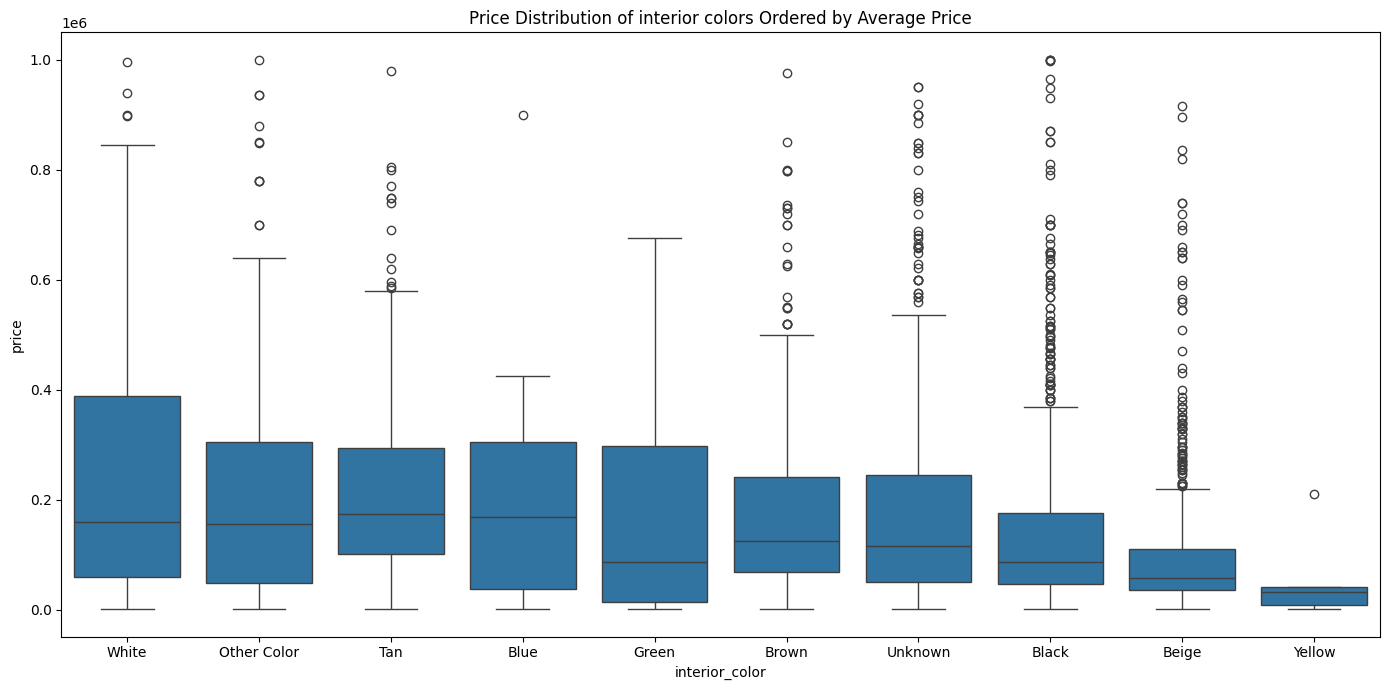

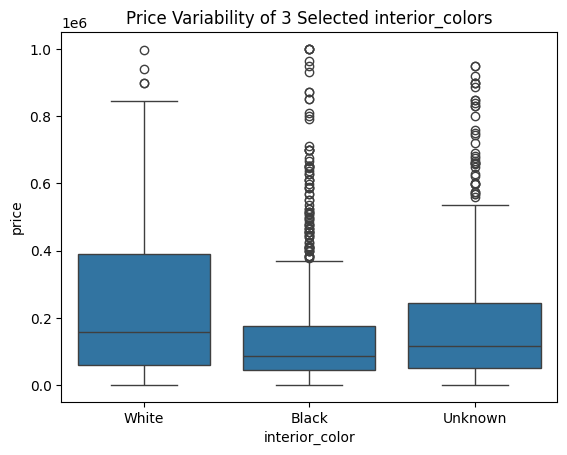

interior_color  Total Count  Outlier Count  % Outliers
         White          105              4        3.81
         Black         1196             83        6.94
       Unknown          733             37        5.05

Verdict: similar medians, many expensive outliers for most colors
 --> probably not a strong predictor


In [26]:

interior_color_totals = X_train["interior_color"].value_counts().reset_index()
interior_color_totals.columns = ["interior_color","Count"]
interior_color_totals.to_csv("interior_color_totals.csv", index=False)
interior_color_counts = X_train["interior_color"].value_counts().head(300)
interior_color_df = interior_color_counts.reset_index()
interior_color_df.columns = ['interior_color', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x="interior_color", y='Count', data=interior_color_df)
plt.title('Frequency of Car interior colors')
plt.tight_layout()
plt.savefig("interior_color_plot.pdf")
plt.show()
first = train_df["interior_color"].value_counts().iloc[0]
thirty = train_df["interior_color"].value_counts().iloc[3] 
total = train_df["interior_color"].nunique()
print("Total amount of interior colors:", total)
print("Amount of cars belonging to most common interior color:", first,"(",interior_color_counts.index[0],")")
print("Amount of cars belonging to 4th most common interior color:", thirty,"(",interior_color_counts.index[3],")")
order = train_df.groupby('interior_color')['price'].mean().sort_values(ascending=False).index
top_30_interior_colors = order[:30]  
subset = train_df[train_df['interior_color'].isin(top_30_interior_colors)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='interior_color', y='price', order=top_30_interior_colors)
plt.title('Price Distribution of interior colors Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["White","Black",'Unknown']
subset = train_df[train_df['interior_color'].isin(selection)].copy()
sns.boxplot(data=subset, x='interior_color', y='price',order = selection)
plt.title("Price Variability of 3 Selected interior_colors")
plt.show()
feature_col = 'interior_color'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: similar medians, many expensive outliers for most colors\n --> probably not a strong predictor")

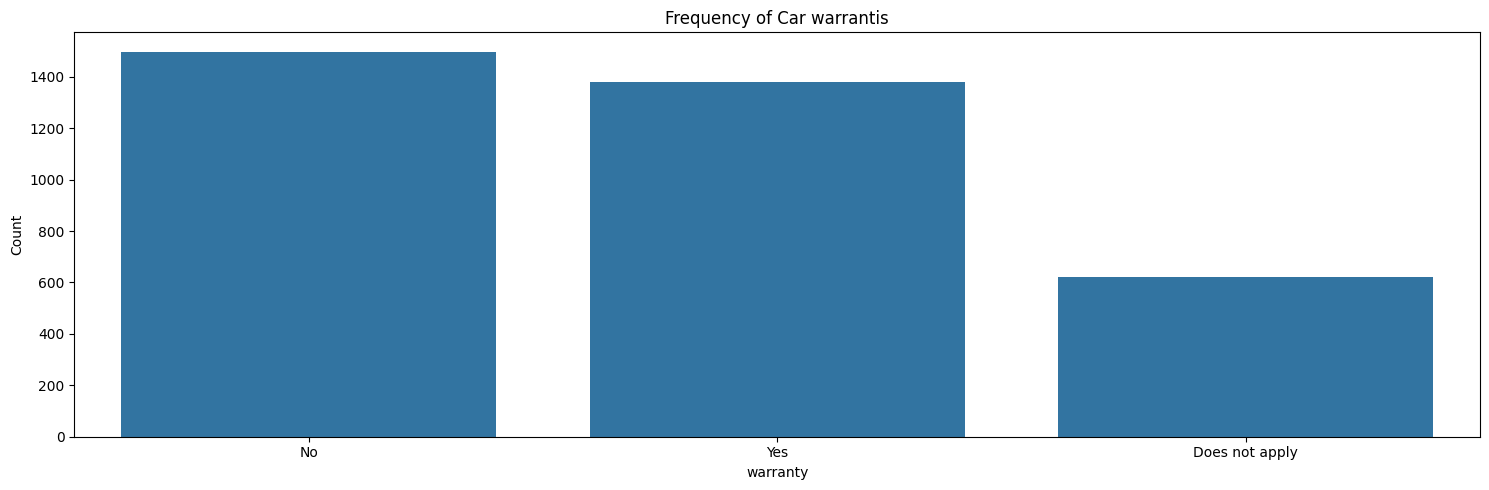

Total amount of exterior colors: 3
Amount of cars belonging to most common warranty status: 1498 ( No )
Amount of cars belonging to 3rd most common warranty status: 621 ( Does not apply )


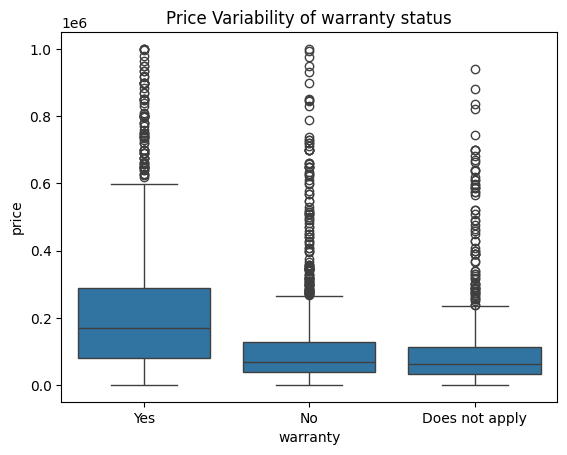

      warranty  Total Count  Outlier Count  % Outliers
           Yes         1380             81        5.87
            No         1498            120        8.01
Does not apply          621             74       11.92

Verdict: Cars with warranty tend to be more expensive
  --> likely a strong predictor


In [30]:

warranty_totals = X_train["warranty"].value_counts().reset_index()
warranty_totals.columns = ["warranty","Count"]
warranty_totals.to_csv("warranty_totals.csv", index=False)
warranty_counts = X_train["warranty"].value_counts().head(300)
warranty_df = warranty_counts.reset_index()
warranty_df.columns = ['warranty', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x="warranty", y='Count', data=warranty_df)
plt.title('Frequency of Car warrantis')
plt.tight_layout()
plt.savefig("warranty_plot.pdf")
plt.show()
first = train_df["warranty"].value_counts().iloc[0]
thirty = train_df["warranty"].value_counts().iloc[2] 
total = train_df["warranty"].nunique()
print("Total amount of exterior colors:", total)
print("Amount of cars belonging to most common warranty status:", first,"(",warranty_counts.index[0],")")
print("Amount of cars belonging to 3rd most common warranty status:", thirty,"(",warranty_counts.index[2],")")
order = train_df.groupby('warranty')['price'].mean().sort_values(ascending=False).index
top_30_warrantys = order[:30]  
subset = train_df[train_df['warranty'].isin(top_30_warrantys)]

selection = ["Yes","No",'Does not apply']
subset = train_df[train_df['warranty'].isin(selection)].copy()
sns.boxplot(data=subset, x='warranty', y='price',order = selection)
plt.title("Price Variability of warranty status")
plt.show()
feature_col = 'warranty'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: Cars with warranty tend to be more expensive\n  --> likely a strong predictor")

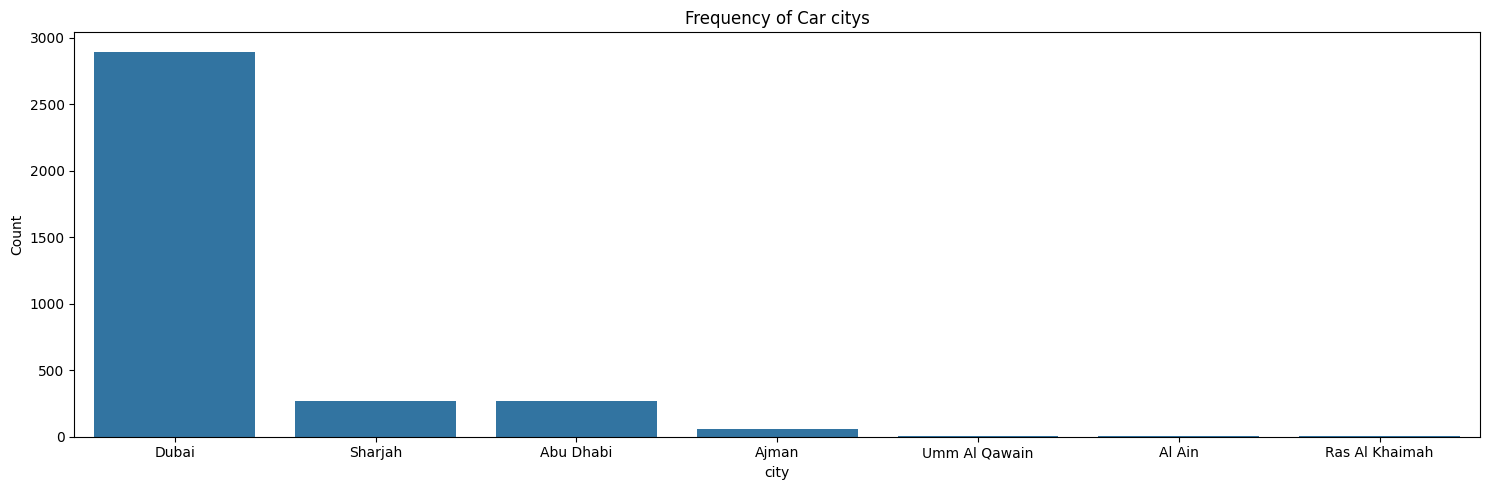

Total amount of cities: 7
Amount of cars belonging to most common city: 2896 ( Dubai )
Amount of cars belonging to 4th most common city: 55 ( Ajman )


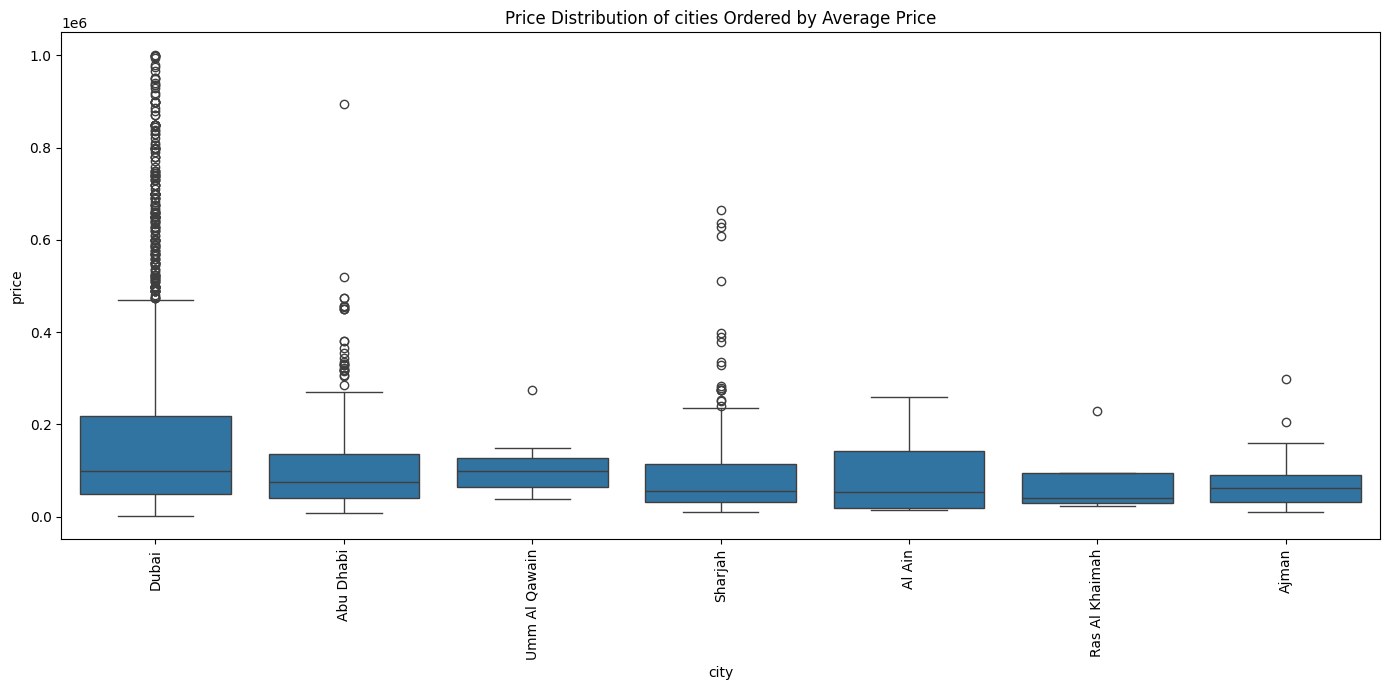

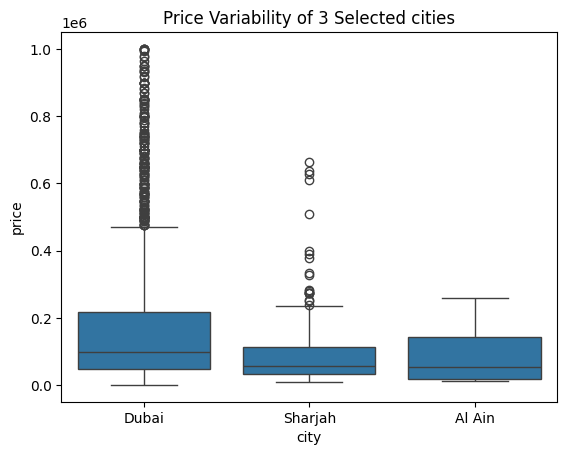

   city  Total Count  Outlier Count  % Outliers
  Dubai         2896            198        6.84
Sharjah          265             19        7.17
 Al Ain            7              0        0.00

Verdict: noticably larger 1.5x IQR beyond Q3 and expensive outliers in Dubai
 --> potentially a strong predictor


In [32]:

city_totals = X_train["city"].value_counts().reset_index()
city_totals.columns = ["city","Count"]
city_totals.to_csv("city_totals.csv", index=False)
city_counts = X_train["city"].value_counts().head(300)
city_df = city_counts.reset_index()
city_df.columns = ['city', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x="city", y='Count', data=city_df)
plt.title('Frequency of Car citys')
plt.tight_layout()
plt.savefig("city_plot.pdf")
plt.show()
first = train_df["city"].value_counts().iloc[0]
thirty = train_df["city"].value_counts().iloc[3] 
total = train_df["city"].nunique()
print("Total amount of cities:", total)
print("Amount of cars belonging to most common city:", first,"(",city_counts.index[0],")")
print("Amount of cars belonging to 4th most common city:", thirty,"(",city_counts.index[3],")")
order = train_df.groupby('city')['price'].mean().sort_values(ascending=False).index
top_30_citys = order[:30]  
subset = train_df[train_df['city'].isin(top_30_citys)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='city', y='price', order=top_30_citys)
plt.xticks(rotation=90)
plt.title('Price Distribution of cities Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["Dubai","Sharjah",'Al Ain']
subset = train_df[train_df['city'].isin(selection)].copy()
sns.boxplot(data=subset, x='city', y='price',order = selection)
plt.title("Price Variability of 3 Selected cities")
plt.show()
feature_col = 'city'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: noticably larger 1.5x IQR beyond Q3 and expensive outliers in Dubai\n --> potentially a strong predictor")

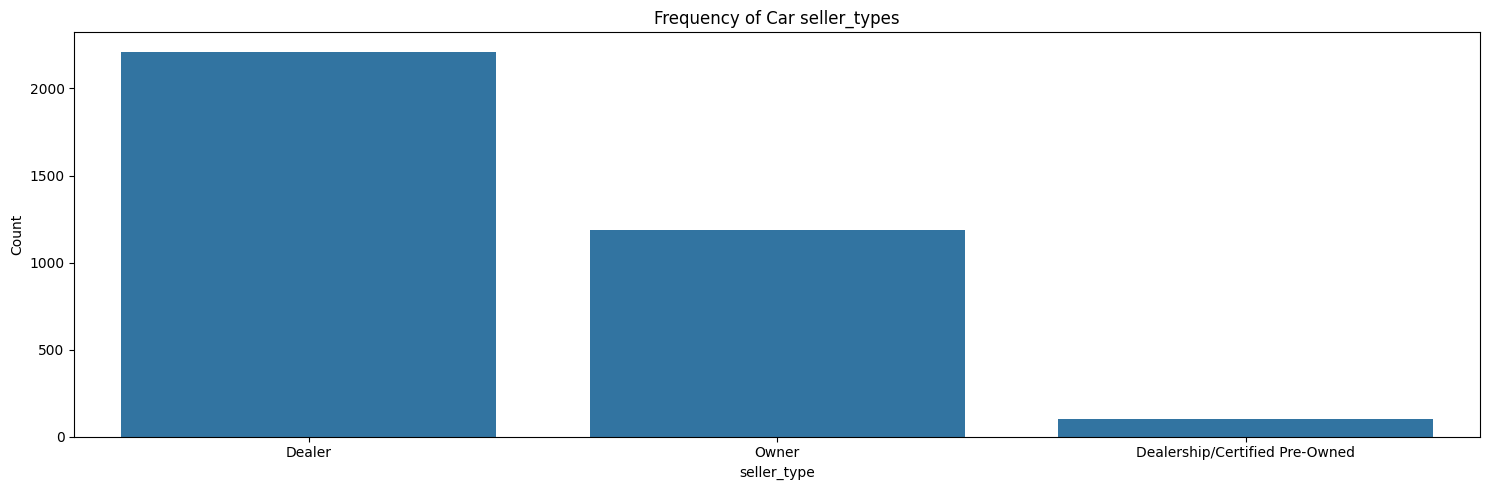

Total amount of seller types: 3
Amount of cars belonging to most common seller type: 2212 ( Dealer )
Amount of cars belonging to 3rd most common seller type: 101 ( Dealership/Certified Pre-Owned )


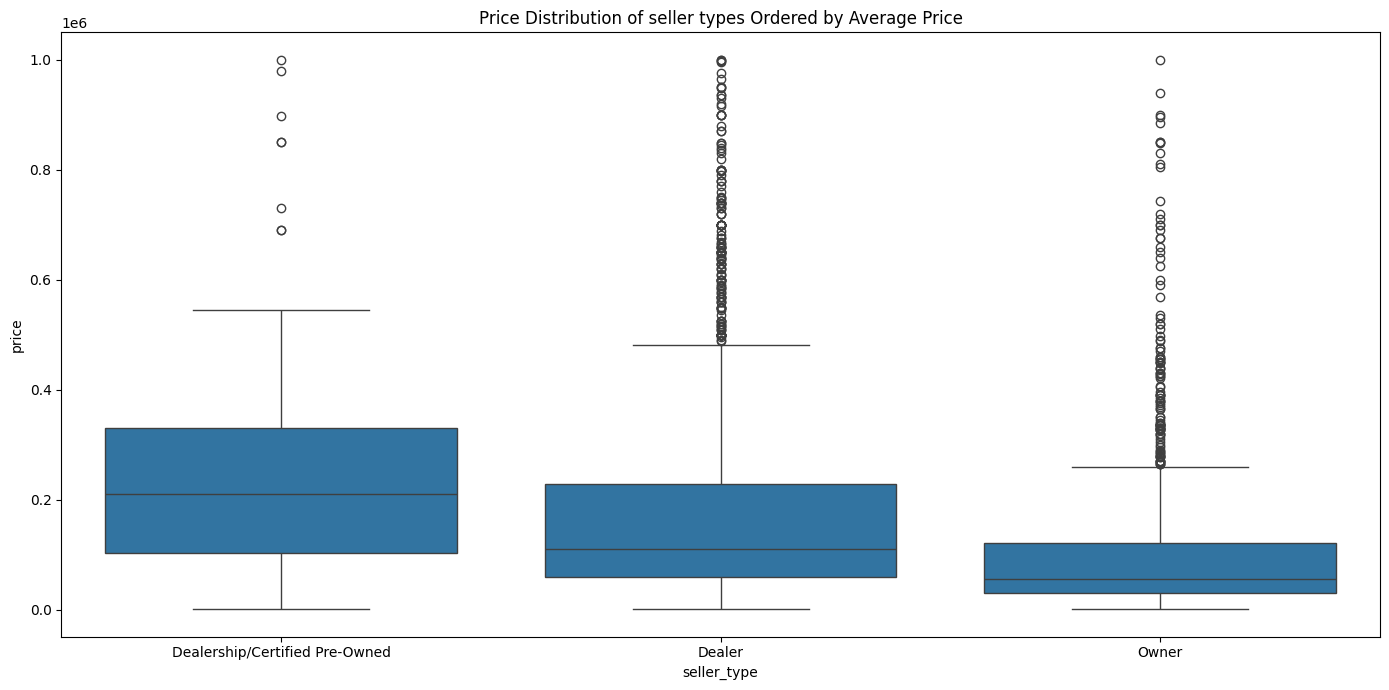

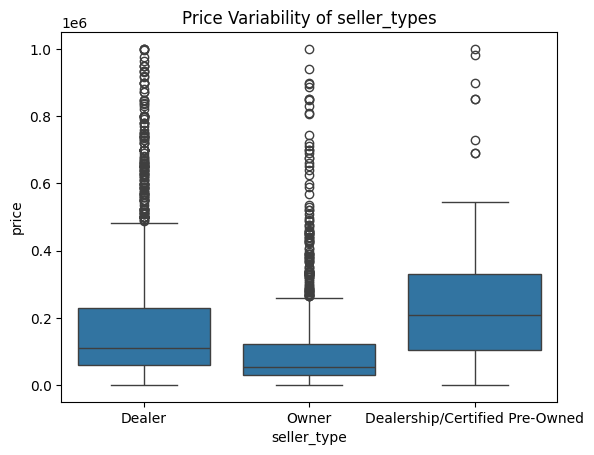

                   seller_type  Total Count  Outlier Count  % Outliers
                        Dealer         2212            155        7.01
                         Owner         1186            116        9.78
Dealership/Certified Pre-Owned          101              8        7.92

Verdict: noisy data with many outliers
 --> predictor may not be reliable on its own


In [34]:

seller_type_totals = X_train["seller_type"].value_counts().reset_index()
seller_type_totals.columns = ["seller_type","Count"]
seller_type_totals.to_csv("seller_type_totals.csv", index=False)
seller_type_counts = X_train["seller_type"].value_counts().head(300)
seller_type_df = seller_type_counts.reset_index()
seller_type_df.columns = ['seller_type', 'Count']

plt.figure(figsize=(15, 5))
sns.barplot(x="seller_type", y='Count', data=seller_type_df)
plt.title('Frequency of Car seller_types')
plt.tight_layout()
plt.savefig("seller_type_plot.pdf")
plt.show()
first = train_df["seller_type"].value_counts().iloc[0]
thirty = train_df["seller_type"].value_counts().iloc[2] 
total = train_df["seller_type"].nunique()
print("Total amount of seller types:", total)
print("Amount of cars belonging to most common seller type:", first,"(",seller_type_counts.index[0],")")
print("Amount of cars belonging to 3rd most common seller type:", thirty,"(",seller_type_counts.index[2],")")
order = train_df.groupby('seller_type')['price'].mean().sort_values(ascending=False).index
top_30_seller_types = order[:30]  
subset = train_df[train_df['seller_type'].isin(top_30_seller_types)]
plt.figure(figsize=(14,7))
sns.boxplot(data=subset, x='seller_type', y='price', order=top_30_seller_types)
plt.title('Price Distribution of seller types Ordered by Average Price')
plt.tight_layout()
plt.show()
selection = ["Dealer",'Owner',"Dealership/Certified Pre-Owned"]
subset = train_df[train_df['seller_type'].isin(selection)].copy()
sns.boxplot(data=subset, x='seller_type', y='price',order = selection)
plt.title("Price Variability of seller_types")
plt.show()
feature_col = 'seller_type'   
    

counts = {}

for category, group in subset.groupby(feature_col):
    values = group["price"]
    
    
    total_count = len(values)

    # Compute outliers
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    # Save both counts
    counts[category] = {
        'total': total_count,
        'outliers': outlier_count
    }

# Print results
data = []
for cat in selection:
    if cat in counts:
        total = counts[cat]['total']
        outliers = counts[cat]['outliers']
        data.append([cat, total, outliers, round(outliers / total * 100, 2)])  # percent outliers

df_counts = pd.DataFrame(data, columns=[feature_col, 'Total Count', 'Outlier Count', '% Outliers'])

print(df_counts.to_string(index=False))
print()
print("Verdict: noisy data with many outliers\n --> predictor may not be reliable on its own")

count      3499.000000
mean     153629.917691
std      169271.516551
min        1000.000000
25%       45000.000000
50%       91000.000000
75%      199250.000000
max      999900.000000
Name: price, dtype: float64


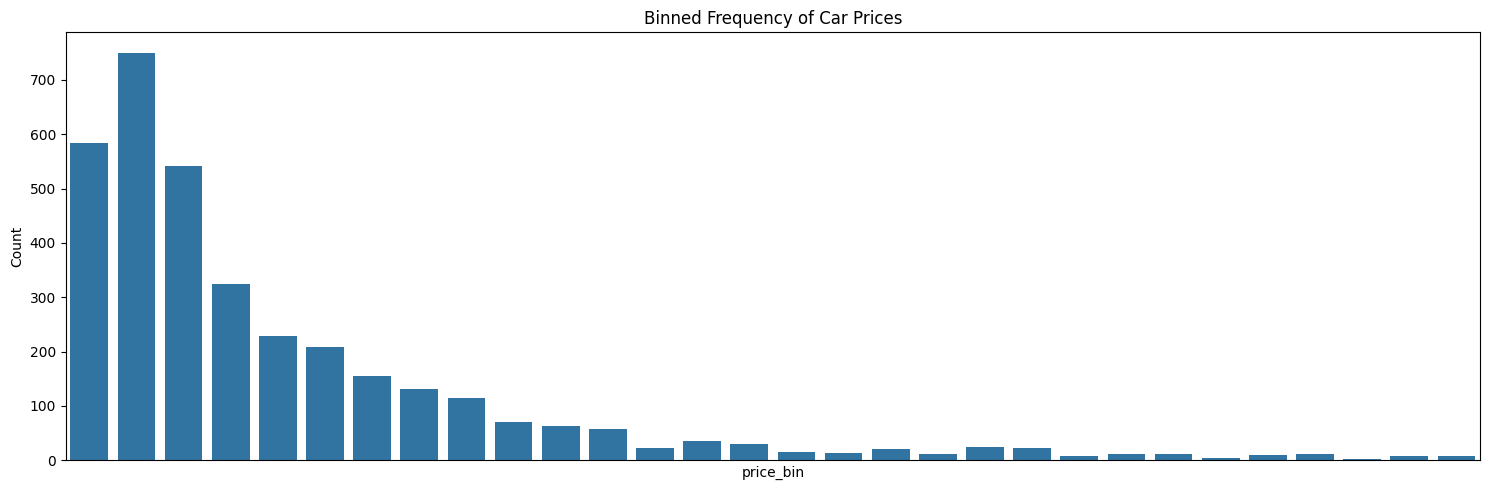

Verdict: data set is noticably right-skewed
 --> simpler models will likely struggle


In [35]:
print(y_train.describe())


price_counts = y_train.value_counts().reset_index()
price_counts.columns = ["price", "Count"]
price_counts.to_csv("price_totals.csv", index=False)
y_price = y_train.reset_index(drop=True).to_frame(name='price')
y_price['Count'] = 1
y_price['price_bin'] = pd.cut(y_price['price'], bins=30)
binned = y_price.groupby('price_bin',observed=True)['Count'].sum().reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(x='price_bin', y='Count', data=binned)
plt.xticks([])
plt.title('Binned Frequency of Car Prices')
plt.tight_layout()
plt.savefig("price_y_plot.png")
plt.show()
print("Verdict: data set is noticably right-skewed\n --> simpler models will likely struggle")